Ce programme est pour but de résoudre la GPE: 
    $$
\mathrm{i} \frac{\partial}{\partial t} \varphi(x ; t)=\left[-\frac{\partial^2}{\partial x^2}+\frac{x^2}{4}+\mathcal{N}|\varphi(x ; t)|^2\right] \varphi(x ; t) \equiv H \varphi(x ; t)
$$

Pour tester le programme et implémenter la méthode de temps réel et de temps imaginaire, on ajoute deux paramètres w et R et résoudre numériquement équation:
   $$
 \frac{\partial}{\partial t} \varphi(x ; t)= R \left[-\frac{\partial^2}{\partial x^2}+w\frac{x^2}{4}+\mathcal{N}|\varphi(x ; t)|^2\right] \varphi(x ; t) \equiv H \varphi(x ; t)
$$
w est un nombre réelle, R = -$\mathrm{i}$ : méthode de temps réel; R = -1 méthode de temps imaginaire

Ici on utilise la méthode "Split-step", c'est à dire on sépare H en deux parties $H = H_{1} + H_{2}$
$$
H_{1} = R \left[w\frac{x^2}{4}+\mathcal{N}|\varphi(x ; t)|^2\right]
\\
H_{2} = R \left[-\frac{\partial^2}{\partial x^2}\right]
$$
On résout $\frac{\partial}{\partial t} \varphi(x ; t)= H_{1}\varphi(x ; t)$ en gardant $H_{1} $ est une constante et puis $\frac{\partial}{\partial t} \varphi(x ; t)= H_{2}\varphi(x ; t)$ par la méthode de spectrale

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

class GPE1D:
    """A class that solves  du/dt = R* [- d^2(u)/(dt)^2 + [w*x^2/4 + N.u^2]*u]
    Spectral stepping method for solving PDEs"""
    def __init__(self, Nx, N, L,w,r = 1): 
        """Initialize the spatial and spectral grids
        If r = 1: method real time, if r = 0: method imaginary time"""
        self.Nx = Nx
        self.N = N
        self.L = L
        self.w = w
        self.x, self.dx = np.linspace(-self.L, self.L, self.Nx, retstep=True)
        self.k = 2*np.pi*np.fft.fftfreq(self.Nx, d=self.dx)        
        if r == 0:
            self.R = -1
            self.u = np.zeros(Nx,dtype = float)
        else:   
            self.R = -1j
            self.u = np.zeros(Nx,dtype = complex)

        
    def initialize(self, func):
        """Set the initial condition"""
        self.u = func(self.x)
        
    def FourierStep(self, dt):
        """Make a step dt forward in time for du/dt = -R*d^2(u)/dt^2"""
        uk = np.fft.fft(self.u)
        uk = np.exp(self.k**2 * dt*self.R)*uk
        if self.R == -1j:
            self.u = np.fft.ifft(uk)
        else:
            self.u = np.fft.ifft(uk).real

    def step(self,dt):
        """Make a step dt forward in time for i*du/dt = H.u"""
        self.FourierStep(dt)
        self.H1Step(dt)
        
    def H1Step(self,dt): 
        """Make a step dt forward in time for i*du/dt = (w*x^2/4 + N.u^2)*u"""
        self.u = self.u * np.exp(self.R*(self.w*self.x**2/4 + self.N * abs(self.u)**2) * dt)
        
'''        
    def H1Step(self,dt):  #methode runga kutta ordre 4
        """Make a step dt forward in time for du/dt = R*[w*x^2/4 + N.u^2]*u"""
        
        if self.R == -1j:
            k1,k2,k3,k4 = np.zeros((4,self.Nx),dtype = complex)
        else:
            k1,k2,k3,k4 = np.zeros((4,self.Nx),dtype = float)
            
        N,w,R,x,u = self.N,self.w,self.R,self.x,self.u
        k1 = R*(w*x**2/4 + N * abs(u)**2)*dt* u
        k2 = R*(w*x**2/4 + N * abs(u+k1/2)**2)*dt* (u+k1/2)
        k3 = R*(w*x**2/4 + N * abs(u+k2/2)**2)*dt* (u+k2/2)
        k4 = R*(w*x**2/4 + N * abs(u+k3)**2)*dt* (u+k3)
        self.u += k1/6 + k2/3 + k3/3 + k4/6 
'''

'        \n    def H1Step(self,dt):  #methode runga kutta ordre 4\n        """Make a step dt forward in time for du/dt = R*[w*x^2/4 + N.u^2]*u"""\n        \n        if self.R == -1j:\n            k1,k2,k3,k4 = np.zeros((4,self.Nx),dtype = complex)\n        else:\n            k1,k2,k3,k4 = np.zeros((4,self.Nx),dtype = float)\n            \n        N,w,R,x,u = self.N,self.w,self.R,self.x,self.u\n        k1 = R*(w*x**2/4 + N * abs(u)**2)*dt* u\n        k2 = R*(w*x**2/4 + N * abs(u+k1/2)**2)*dt* (u+k1/2)\n        k3 = R*(w*x**2/4 + N * abs(u+k2/2)**2)*dt* (u+k2/2)\n        k4 = R*(w*x**2/4 + N * abs(u+k3)**2)*dt* (u+k3)\n        self.u += k1/6 + k2/3 + k3/3 + k4/6 \n'

In [ ]:
def advance(GPE, dt, Nt): #Advance GPE Nt pas d'intervalle dt
    for _ in range(Nt):
        GPE.step(dt)

In [ ]:
class Gaussian:
    """Gaussian function"""
    def __init__(self, width, amplitude, x0):
        """Create Gaussian with the given width and amplitude, centered at x = x0"""
        self.width = width
        self.amp = amplitude
        self.x0 = x0
        
    def __call__(self, x):
        """Evaluate the function for the values of x"""
        return self.amp * np.exp(-(x-self.x0)**2 / self.width**2)
    
# create a Gaussian object
gauss = Gaussian(5,0.532, 0) 

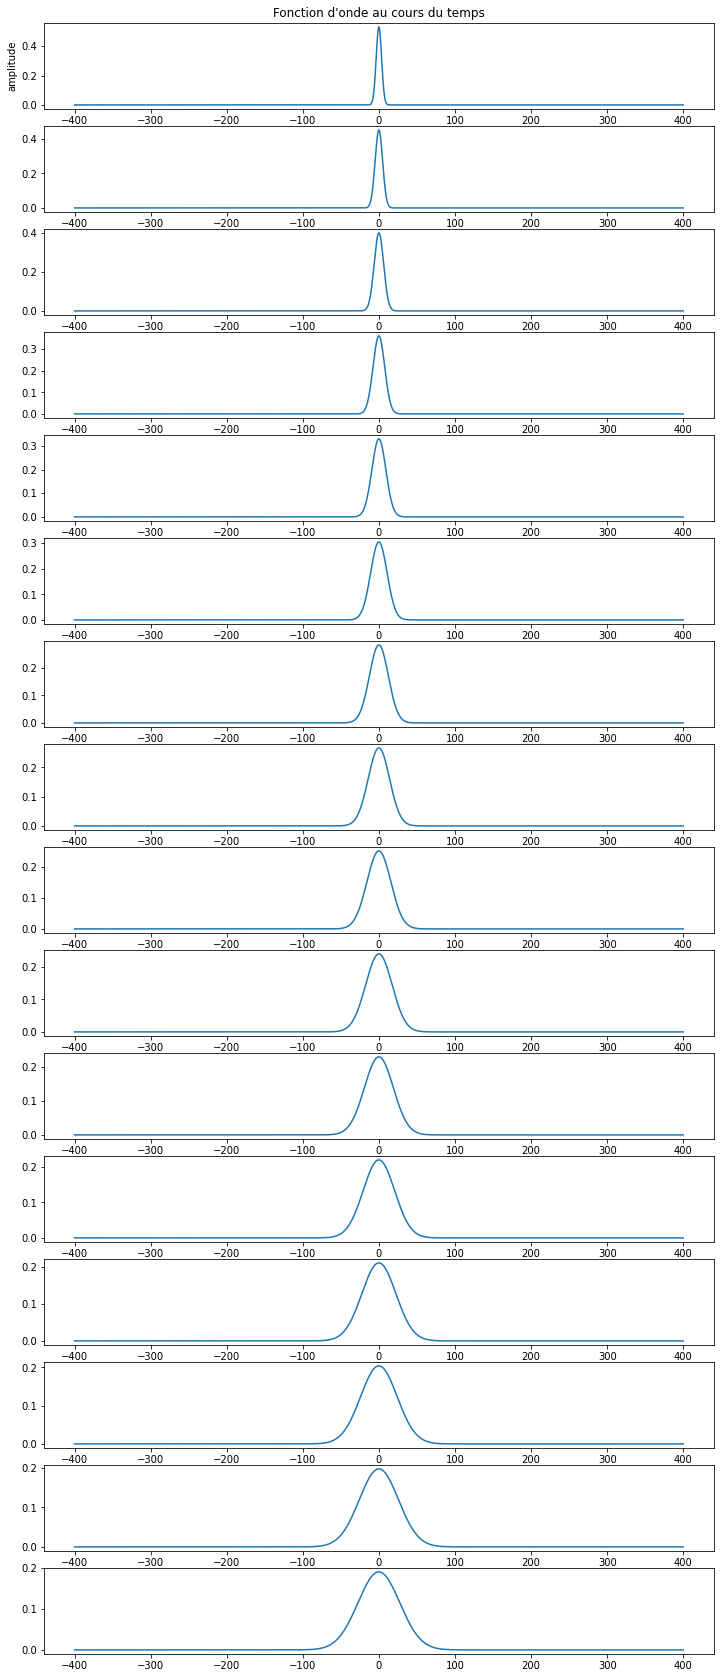

In [ ]:
#Test for w = 0, N = 0, R = 0: étalement d'onde gaussienne
w = 0           # Valeur de w dans l'equation
N = 0        # Valeur de N dans l'equation
Nx = 4000      # Nombre de pas de x
L = 400        # x_max; dx = L/Nx
Nt = 1000      # Nombre de pas de temps
dt = 0.003         # Intervalle de temp; T = Nt * dt
NT = 15       #Nombre de pas de T
GPE = GPE1D(Nx,N,L,w,1)
GPE.initialize(gauss)
advance(GPE,dt,Nt)
x = GPE.x

fig, ax = plt.subplots(NT+1,figsize=(12, 2*NT))
ax[0].plot(x, gauss(x), label='u(t=0)')
ax[0].set_xlabel('x [cm]')
ax[0].set_ylabel('amplitude')
ax[0].set_title("Fonction d'onde au cours du temps")
for i in range(NT):
    advance(GPE,dt,Nt)
    ax[i+1].plot(x, abs(GPE.u))
